# Graphing Helpers

Helper functions which graph various different streaming parameters 

In [3]:
%run StatsHelpers.ipynb

999
2000
1000000
QUIC with loss sample
C:\Users\Jamie\Documents\UVic\4th Year\Fall 2021\CSC 499 - QUIC\jupyter-csc499\499-Visualization\data\benchmarking-loss\TCP\festive\2Mbps\0.05\no-pacing\
TCP | festive | 2Mbps (2000000bps) | 5.0% loss | no pacing
444
222
QUIC | festive | 1Mbps (1000000bps) | 0.0% loss | pacing
QUIC | festive | 1Mbps (1000000bps) | 1.0% loss | no pacing
QUIC | festive | 2Mbps (2000000bps) | 5.0% loss | no pacing
QUIC | tobasco | 500Kbps (500000bps) | 1.0% loss | pacing
QUIC | tobasco | 2Mbps (2000000bps) | 2.0% loss | pacing
QUIC | tobasco | 3Mbps (3000000bps) | 2.0% loss | no pacing
QUIC | tobasco | 3Mbps (3000000bps) | 5.0% loss | pacing
QUIC | tobasco | 5Mbps (5000000bps) | 5.0% loss | no pacing
festive over QUIC @ 2Mbps with 0% loss (with pacing)
festive over QUIC @ 2Mbps with 5.0% loss (no pacing)
Mean Quality Level - QUIC 500Kbps:  0.7278911564625851
Mean Quality Level - TCP  500Kbps:  0.9099099099099099
Mean Quality Level - QUIC 1Mbps:  1.5
Mean Quality Leve

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.lines import Line2D

In [5]:
segmentsToGraph = 50 # Set this so we can control how much of the QUIC/TCP data we're graphing

## Quality Level vs Time

In [6]:
# Helper function to get x and y data for graphing
# maxSegments is upper bound on amount of data to return
def getQualityData(sim, maxSegments = segmentsToGraph):
    (adaptHeaders, adaptData) = readAdaptationLog(sim.path)
    
    # Pull out the two columns we care about as np arrays
    npAdaptData = np.array(adaptData)
    adaptSegments = npAdaptData[:,0]
    adaptQuality = npAdaptData[:,1]
    
    # Trim data to size
    adaptSegments = adaptSegments[:maxSegments]
    adaptQuality = adaptQuality[:maxSegments]
    
    return (adaptSegments, adaptQuality)


def setIntegerYTickInterval(ax):
    # https://stackoverflow.com/questions/27496737/how-to-force-matplotlib-to-display-only-whole-numbers-on-the-y-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


# Helper function to get x and y data when graphing quality comparison plots
# segmentCount is an upper bound on the number of segments to return
def getQualityComparisonData(sim1, sim2, segmentCount = segmentsToGraph):
    segments1, quality1 = getQualityData(sim1)
    segments2, quality2 = getQualityData(sim2)
    
    # If no count is given, use the longer of the two inputs

    count1 = len(segments1)
    count2 = len(segments2)
    if segmentCount is None:
        segmentCount = min(count1, count2)
    else:
        segmentCount = min(count1, count2, segmentCount)
    
    segments = np.arange(segmentCount)
    quality1 = quality1[:segmentCount]
    quality2 = quality2[:segmentCount]
    
    return (segments, quality1, quality2)

In [13]:
'''Graphs segment qualities over time

parentDir is the directory containing the log files for the simulation run in question.
'''
def graphAdaptationLevel(sim):
    segments, quality = getQualityData(sim)    
    
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(111)
    
    descriptionString = "{} over {} @ {} with {}".format(sim.algo, sim.proto, sim.rateStr, sim.getLossString())
    ax.set_title('Video Quality by Segment: '+ descriptionString)

    plt.xlabel("Video Segment")
    plt.ylabel("Quality Level")
    
    # Set the tick distribution for quality axis
    setIntegerYTickInterval(ax)

    # Set the tick distribution for x axis to every 10th segment
    maxSegment = segments[-1]
    xTickMax = (maxSegment/10) * 10 + 10
    plt.xticks(np.arange(0, xTickMax, 10))

    ax.plot(segments, quality, "o")


''' Graph the adaptation levels for two simulations on one figure
'''
def compareAdaptationLevelsOverlay(sim1, sim2, label1, label2):
    segments, quality1, quality2 = getQualityComparisonData(sim1, sim2)
    
    # Plot both qualities along the same axis   
    fig = plt.figure(figsize=(15, 3))
    ax = fig.add_subplot(111)
    
    descriptionString = "{} @ {} with {}".format(sim1.algo, sim1.rateStr, sim1.getLossString())
    ax.set_title('{} vs {}: {}'.format(label1, label2, descriptionString))
    
    setIntegerYTickInterval(ax)
    
    ax.plot(segments, quality1, 'bx', label=label1)
    ax.plot(segments, quality2, 'g+', label=label2)

    plt.xlabel("Video Segment")
    plt.ylabel("Quality Level")
    
    plt.legend()
    plt.show()


''' Graph the adaptation levels for the QUIC and TCP simulations side-by-side
'''
def compareAdaptationLevelsSeparate(sim1, sim2, label1, label2):
    segments, quality1, quality2 = getQualityComparisonData(sim1, sim2)
    
    # Plot the qualities in separate figures   
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(15, 3))

    descriptionString = "{} @ {} with {}".format(sim1.algo, sim1.rateStr, sim1.getLossString())
    fig.suptitle('{} vs {}: {}'.format(label1, label2, descriptionString), fontsize=14, y=1.1)

    ax1.set_title(label1)
    ax2.set_title(label2)
    
    # Turn on the TCP plot's tick labels manually. They've been turned of by
    # sharing the axis between subplots.
    ax2.yaxis.set_tick_params(labelleft=True)
    
    # Enforce integer values for y axis ticks
    setIntegerYTickInterval(ax1)
    setIntegerYTickInterval(ax2)
    
    ax1.plot(segments, quality1, 'bo', label=label1)
    ax2.plot(segments, quality2, 'go', label=label2)

    ax1.set_xlabel("Video Segment")
    ax2.set_xlabel("Video Segment")
    ax1.set_ylabel("Quality Level")
    ax2.set_ylabel("Quality Level")
    
    plt.show()

Single quality level graph for QUIC data:
Side-by-side comparison


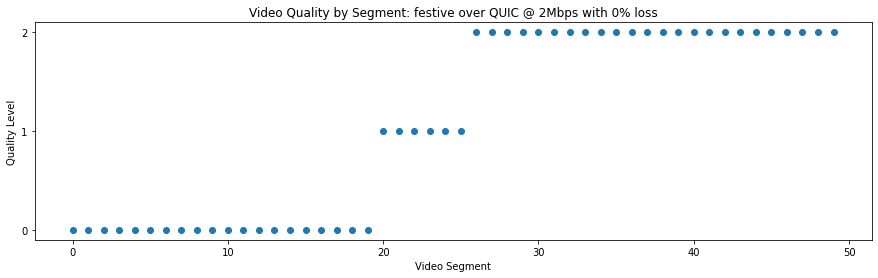

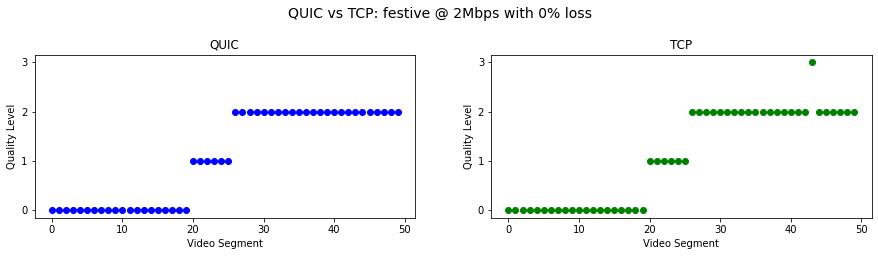

Overlayed comparison


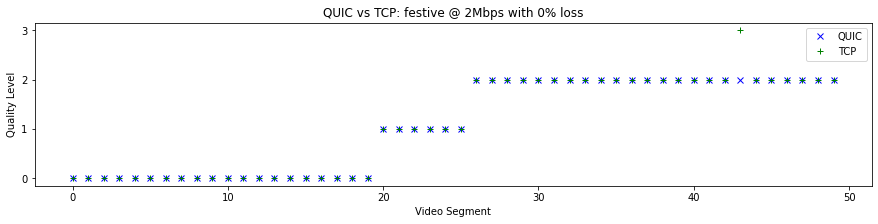

In [14]:
# Demo of how we can use the above functions to graph quality data

print ("Single quality level graph for QUIC data:")
graphAdaptationLevel(sampleQuicSim)

print ("Side-by-side comparison")
compareAdaptationLevelsSeparate(sampleQuicSim, sampleTcpSim, 'QUIC', 'TCP')

print ("Overlayed comparison")
compareAdaptationLevelsOverlay(sampleQuicSim, sampleTcpSim, 'QUIC', 'TCP')

## Buffer Level vs Time

In [7]:
def getBufferData(sim):
    # Ignore headers
    (_, bufferData) = readBufferLog(sim.path) 

    # Split out the columns
    npBufferData = np.array(bufferData)
    timestamps = npBufferData[:,0]
    levels = npBufferData[:,1]

    return (timestamps, levels)


def getBufferComparisonData(sim1, sim2):
    ts1, levels1 = getBufferData(sim1)
    ts2, levels2 = getBufferData(sim2)
    
    # Remove the timestamps from the longer run that go past where the other stopped.
    endTs1 = ts1[-1]
    endTs2 = ts2[-1]
    
    if abs(endTs1 - endTs2) > 1:   
        if endTs1 < endTs2:
            # Trim ts2 and levels2
            endIndex = np.argmax(ts2 > endTs1)
            ts2 = ts2[:endIndex]
            levels2 = levels2[:endIndex]
        else:
            # Trim ts1 and levels1
            endIndex = np.argmax(ts1 > endTs2)
            ts1 = ts1[:endIndex]
            levels1 = levels1[:endIndex]
    
    return (ts1, ts2, levels1, levels2)

In [8]:
# Graph buffer level of a single simulation over time
def graphBufferLevel(sim):
    times, levels = getBufferData(sim)
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times, levels)
    
    plt.show()

QUIC buffer level graph demo


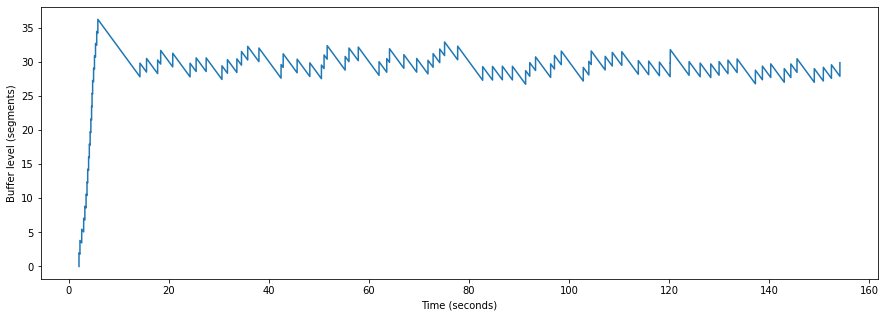

TCP buffer level graph demo


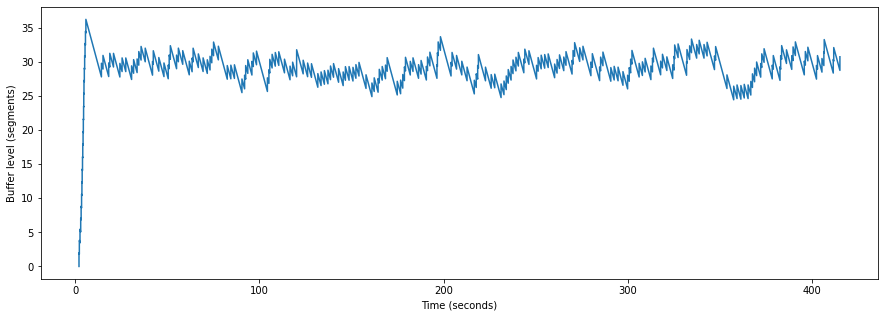

In [9]:
print ("QUIC buffer level graph demo")
graphBufferLevel(sampleQuicSim)

print ("TCP buffer level graph demo")
graphBufferLevel(sampleTcpSim)

In [10]:
# Graph buffer levels of two simulations overlayed on a single graph
def graphBufferLevelComparison(sim1, sim2, label1, label2):
    buffData = getBufferComparisonData(sim1, sim2)
    times1, times2, levels1, levels2 = buffData
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times1, levels1, ':', label=label1)
    ax.plot(times2, levels2, ':', label=label2)
    
    plt.legend()
    plt.show()

Buffer level comparison for normal rate


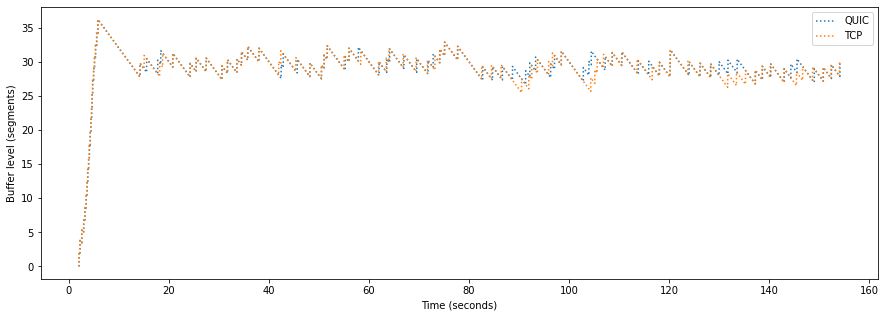

Buffer level comparison for slow rate


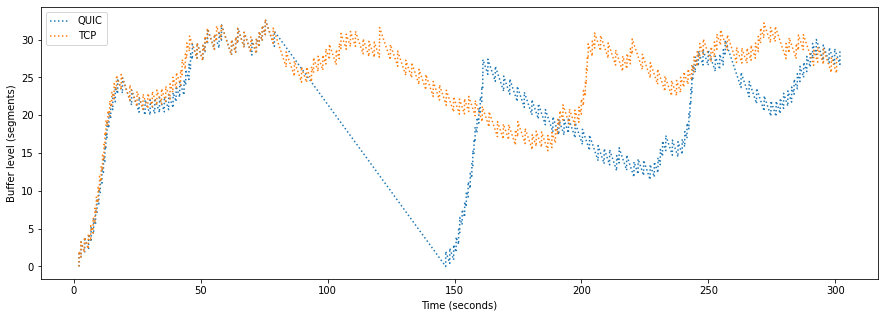

In [11]:
print ("Buffer level comparison for normal rate")
graphBufferLevelComparison(sampleQuicSim, sampleTcpSim, 'QUIC', 'TCP')

print ("Buffer level comparison for slow rate")
graphBufferLevelComparison(sampleSlowQuicSim, sampleSlowTcpSim, 'QUIC', 'TCP')

In [12]:
def getUnderflowTimes(sim):
    (_, intervals) = readUnderflowLog(sim.path)
    return intervals

# Graph the buffer level over time, with markers showing buffer underflow 
# detection and recovery events
def graphBufferWithUnderflow(sim):
    times, levels = getBufferData(sim)
    underflowTimes = getUnderflowTimes(sim)
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times, levels, label="Buffer Level")
    
    # Add underflow lines to legend
    handles, labels = ax.get_legend_handles_labels()
    redLine = Line2D([0], [0], label='Underflow Detected', color='r')
    greenLine = Line2D([0], [0], label="Underflow Resolved", color ='g')    
    handles.extend([redLine, greenLine])
    
    # Mark underflows with vertical lines
    for (start, end) in underflowTimes:        
        plt.axvline(x=start, color="r")
        plt.axvline(x=end, color="g")

    plt.legend(handles=handles)
    plt.show()

Buffer level over time with underflow annotations
Malformed buffer underflow log. Likely that QUIC failed near time 330.524


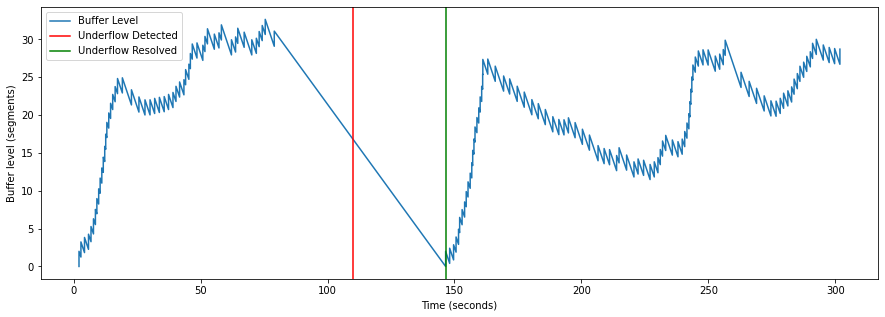

In [13]:
print ("Buffer level over time with underflow annotations")
graphBufferWithUnderflow(sampleSlowQuicSim)

## Simulation Timeline Graphing

Allows us to look at the buffer level, quality level, and throughput data for a simulation all along one timeline

In [14]:
def getPlaybackData(sim):
    _, playbackRows = readPlaybackLog(sim.path)

    npData = np.array(playbackRows)
    segments = npData[:,0]
    playbackTimes = npData[:,1]
    qualityLevels = npData[:,2]
    
    return (segments, playbackTimes, qualityLevels)


def getDownloadData(sim):
    _, downloadRows = readDownloadLog(sim.path)
    
    npData = np.array(downloadRows)
    segments = npData[:,0]
    startTimes = npData[:,1]
    endTimes = npData[:,2]
    sizes = npData[:,3]
    
    return (startTimes, endTimes, sizes)

In [15]:
def graphFullTimeline(sim):
    bufferTimes, bufferLevels = getBufferData(sim)
    underflowTimes = getUnderflowTimes(sim)
    segments, playbackTimes, quality = getPlaybackData(sim)
    startTimes, endTimes, segmentSizes = getDownloadData(sim)
    downloadTimes, downloadSizes = readThroughputLog(sim.path)
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex='col', figsize=(15, 12))

    # Buffer level plot (ax1)
    ax1.set_title("Buffer Level")   
    ax1.set_ylabel("Buffer level (segments)")
    
    ax1.plot(bufferTimes, bufferLevels, label="Buffer Level")
    
    # Add underflow lines to legend
    handles, labels = ax1.get_legend_handles_labels()
    redLine = Line2D([0], [0], label='Underflow Detected', color='r')
    greenLine = Line2D([0], [0], label="Underflow Resolved", color ='g')    
    handles.extend([redLine, greenLine])
    
    # Mark underflows with vertical lines
    for (start, end) in underflowTimes:        
        ax1.axvline(x=start, color="r")
        ax1.axvline(x=end, color="g")

    ax1.legend()

    # Playback quality plot (ax2)
    ax2.set_title("Playback Quality Levels")        
    ax2.set_ylabel("Playback quality level")
    setIntegerYTickInterval(ax2)
    
    ax2.plot(playbackTimes, quality, "o")
        
    # Download size plot (ax3)
    ax3.set_title("Segment Downloads")
    ax3.set_ylabel("Segment Download Size (bytes)")
    
    tickOffset = max(segmentSizes) / 80.0
    for segment in range (len(segments)):
        size = segmentSizes[segment]
        start = startTimes[segment]
        end = endTimes[segment]
        
        ax3.hlines(y=size, xmin=start, xmax=end, linewidth=1)
        ax3.vlines(x=start, ymin=size-tickOffset, ymax=size+tickOffset, linewidth=1)
        ax3.vlines(x=end, ymin=size-tickOffset, ymax=size+tickOffset, linewidth=1)
    
    # Throughput plot (ax4)
    ax4.set_title("Throughput (data received by client)")
    ax4.set_ylabel("Datagram Size (Bytes)")
    
    ax4.scatter(downloadTimes, downloadSizes, s=1)
    
    # Average Throughput plot (ax5)
    ax5.set_title("Data received each second")
    ax5.set_xlabel("Time (seconds)")    
    ax5.set_ylabel("Data Received (bytes)")    
    
    # Build up a bucket for each second
    maxWholeSecond = int(np.floor(downloadTimes[-1]))
    avgThroughputBars = np.zeros(maxWholeSecond + 1)
    for (time, size) in zip(downloadTimes, downloadSizes):
        bucket = int(np.floor(time))
        avgThroughputBars[bucket] += size

    ax5.bar(np.arange(len(avgThroughputBars)), avgThroughputBars)
        
    plt.show()

Full timeline for QUIC 500Kbps
Malformed buffer underflow log. Likely that QUIC failed near time 330.524


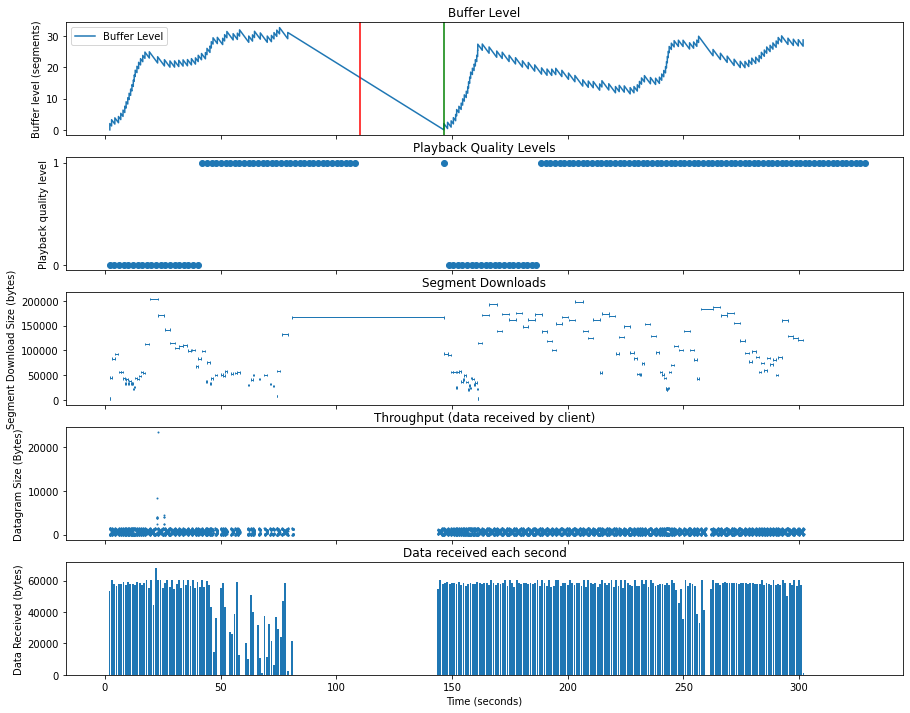

In [16]:
print ("Full timeline for QUIC 500Kbps")
graphFullTimeline(sampleSlowQuicSim)

Full timeline for TCP 500Kbps


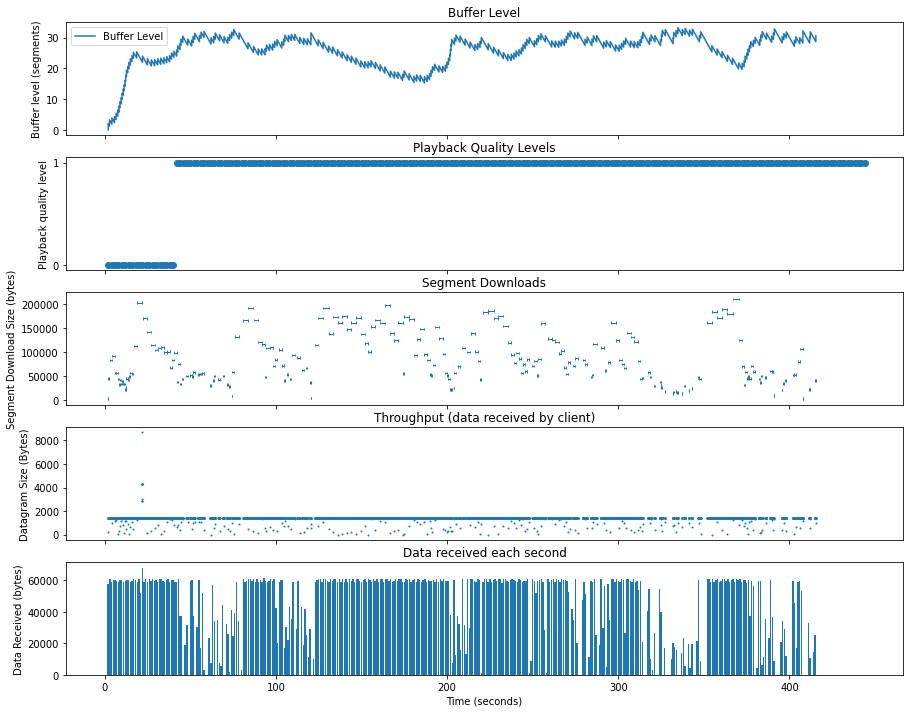

In [17]:
print ("Full timeline for TCP 500Kbps")
graphFullTimeline(sampleSlowTcpSim)

Full timeline for QUIC 2Mbps
Malformed buffer underflow log. Likely that QUIC failed near time 184.045


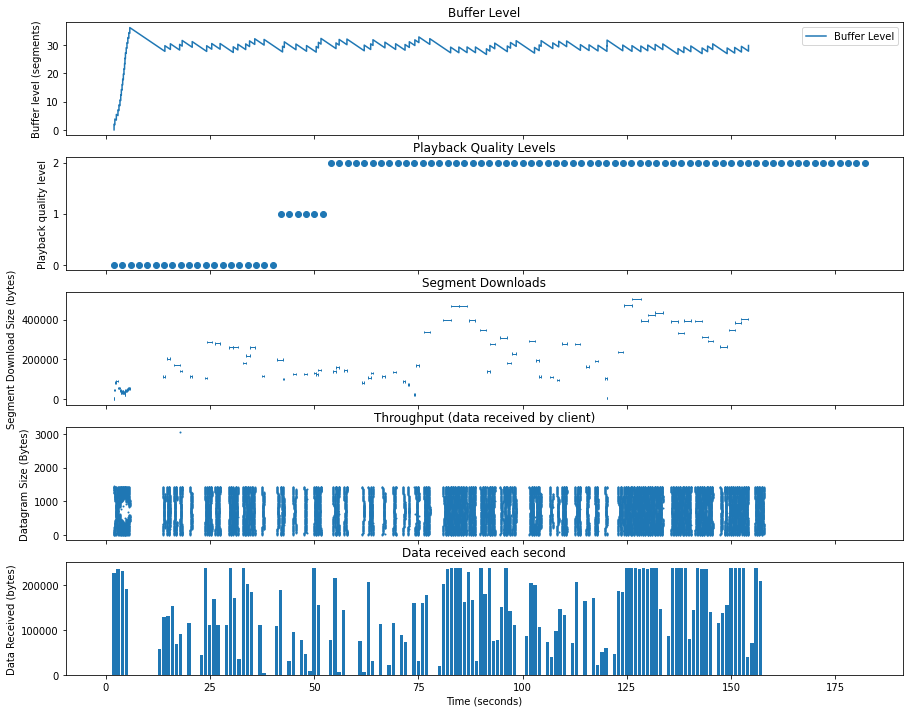

In [18]:
print ("Full timeline for QUIC 2Mbps")
graphFullTimeline(sampleQuicSim)

## Efficiency Graphing

In [19]:
def getEfficiencyComparisonData(sim1, sim2):
    segCount1 = sim1.countSegments()
    segCount2 = sim2.countSegments()

    inefficiencies1 = inefficiencyScores(sim1)
    inefficiencies2 = inefficiencyScores(sim2)
    
    if segCount1 < segCount2:
        inefficiencies2 = inefficiencies2[:len(inefficiencies1)]
    elif segCount1 > segCount2:
        inefficiencies1 = inefficiencies1[:len(inefficiencies2)]

    segCount = min(segCount1, segCount2)
    times = np.arange(segCount) * 2
        
    return (times, inefficiencies1, inefficiencies2)

In [20]:
def graphEfficiency(sim):
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(111)

    plt.xlabel("Seconds")
    plt.ylabel("Inefficiency")
    
    # Set the tick distribution for quality axis
    setIntegerYTickInterval(ax)

    times = np.arange(sim.countSegments()) * 2
    data = inefficiencyScores(sim)
    
    ax.plot(times, data)
    
    
def compareEfficiencySeparate(sim1, sim2, label1, label2):
    # Plot the qualities in separate figures
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(15, 3))

    ax1.set_title(label1)
    ax2.set_title(label2)

    times, inefficiencies1, inefficiencies2 = getEfficiencyComparisonData(sim1, sim2)    
    
    # Turn on the TCP plot's tick labels manually. They've been turned of by
    # sharing the axis between subplots.
    ax2.yaxis.set_tick_params(labelleft=True)
    
    # Enforce integer values for y axis ticks
    setIntegerYTickInterval(ax1)
    setIntegerYTickInterval(ax2)
    
    ax1.plot(times, inefficiencies1, 'bo', label=label1)
    ax2.plot(times, inefficiencies2, 'go', label=label2)

    ax1.set_xlabel("Time (seconds)")
    ax2.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Inefficiency")
    ax2.set_ylabel("Inefficiency")
    
    plt.show()

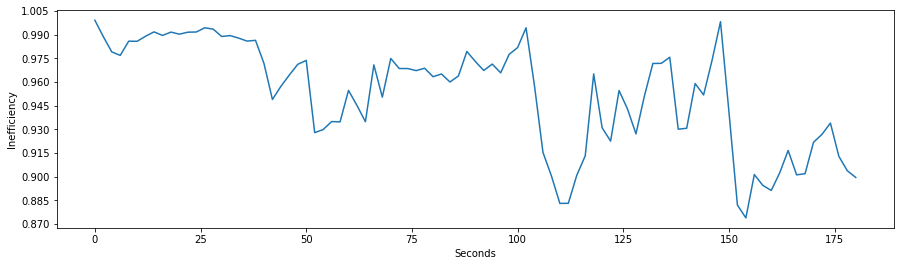

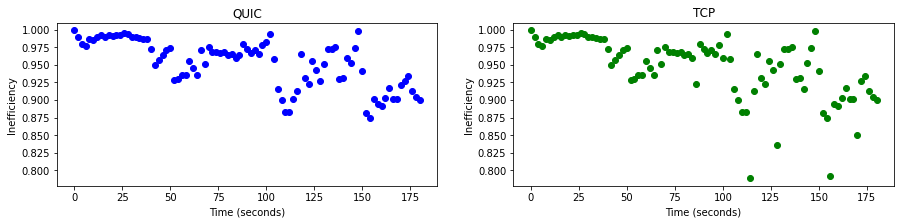

In [21]:
graphEfficiency(sampleQuicSim)
compareEfficiencySeparate(sampleQuicSim, sampleTcpSim, 'QUIC', 'TCP')

In [22]:
def compareEfficiencyOverlay(sim1, sim2, label1, label2):
    times, inefficiencies1, inefficiencies2 = getEfficiencyComparisonData(sim1, sim2)    

    # Plot both datasets along the same axis   
    fig = plt.figure(figsize=(15, 3))
    ax = fig.add_subplot(111)
    
    setIntegerYTickInterval(ax)
    
    ax.plot(times, inefficiencies1, 'b:', label=label1)
    ax.plot(times, inefficiencies2, 'g:', label=label2)

    plt.xlabel("Video Segment")
    plt.ylabel("Inefficiency")
    
    plt.legend()
    plt.show()

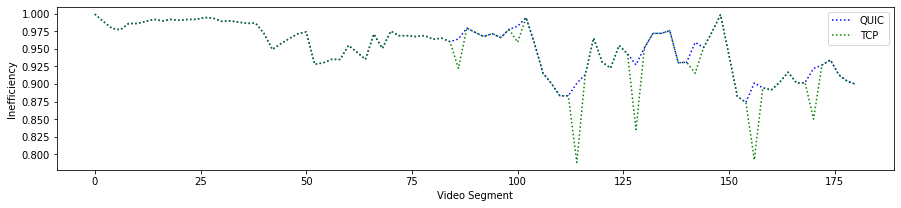

In [23]:
compareEfficiencyOverlay(sampleQuicSim, sampleTcpSim, 'QUIC', 'TCP')

## Stability Graphing

In [24]:
def graphStability(sim):
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(111)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Instability")
    
    # Set the tick distribution for quality axis
    setIntegerYTickInterval(ax)

    data = instabilityEachSecond(sim)
    times = np.arange(len(data))
    
    ax.plot(times, data)

Stability for QUIC sample
Stability for TCP sample


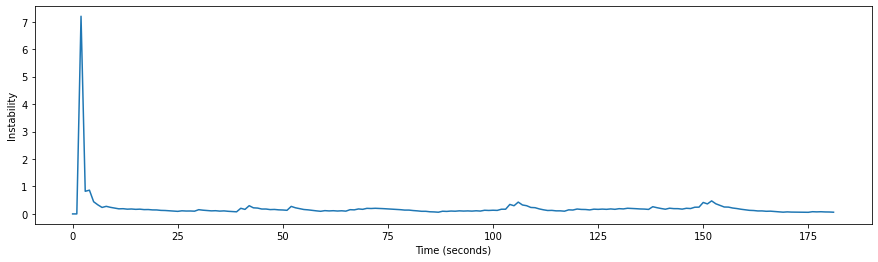

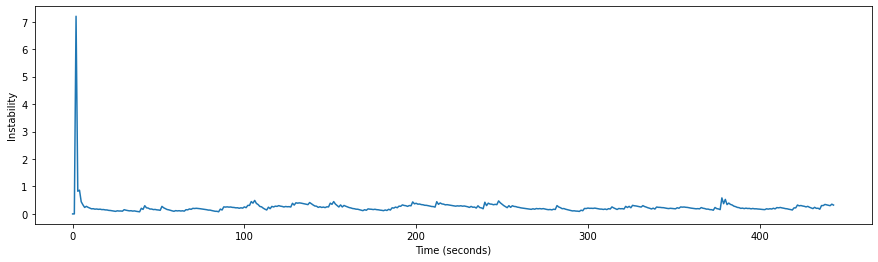

In [25]:
print ('Stability for QUIC sample')
graphStability(sampleQuicSim)

print ('Stability for TCP sample')
graphStability(sampleTcpSim)

In [26]:
def getStabilityComparisonData(sim1, sim2):
    stab1 = instabilityEachSecond(sim1)
    stab2 = instabilityEachSecond(sim2)
    
    duration = min(len(stab1), len(stab2))
    if len(stab1) > duration:
        stab1 = stab1[:duration]
    if len(stab2) > duration:
        stab2 = stab2[:duration]
    
    times = np.arange(duration)
    return times, stab1, stab2

In [27]:
def compareStabilityOverlay(sim1, sim2, label1, label2):
    times, stab1, stab2 = getStabilityComparisonData(sim1, sim2)    

    # Plot both datasets along the same axis   
    fig = plt.figure(figsize=(15, 3))
    ax = fig.add_subplot(111)
    
    setIntegerYTickInterval(ax)
    
    ax.plot(times, stab1, 'b:', label=label1)
    ax.plot(times, stab2, 'g:', label=label2)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Instability")
    
    plt.legend()
    plt.show()

QUIC vs TCP samples


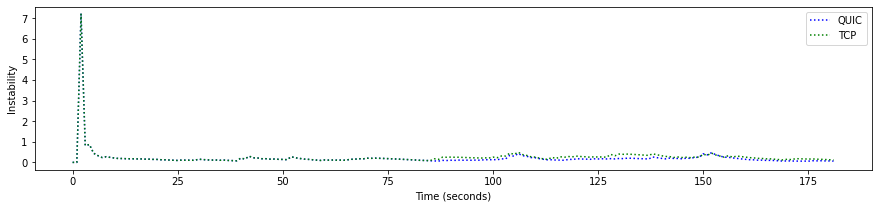

QUIC vs TCP lossy samples


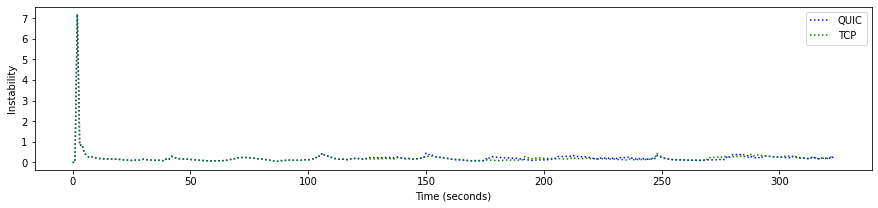

In [28]:
print ('QUIC vs TCP samples')
compareStabilityOverlay(sampleQuicSim, sampleTcpSim, 'QUIC', 'TCP')

print ('QUIC vs TCP lossy samples')
compareStabilityOverlay(sampleLossyQuicSim, sampleLossyTcpSim, 'QUIC', 'TCP')

## Graphing of groups of data points
Graphing utilities for means, medians, etc.

In [29]:
def singleBoxPlot(data, label, ylabel, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    _ = ax.boxplot(data, labels=[label])

def comparisonBoxPlot(data, labels, ylabel, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    _ = ax.boxplot(data, labels=labels)

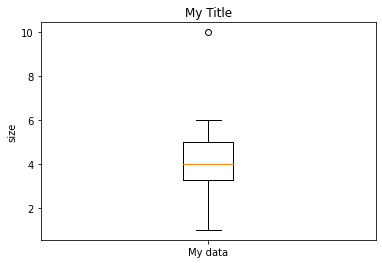

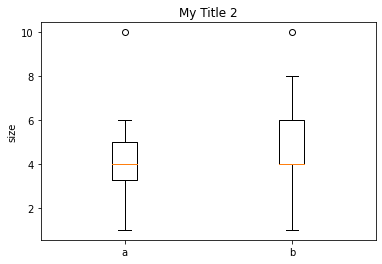

In [30]:
data1 = [1,2,3,4,4,4,5,5,6,10]
data2 = [1,3,4,4,4,5,6,8,10]
singleBoxPlot(data1, "My data", "size", "My Title")
comparisonBoxPlot([data1, data2], ['a', 'b'], 'size', 'My Title 2')

In [29]:
def colorBoxplotPair(bp, colors):
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)

        
# Create a boxplot with several groups of data, with a quic dataset and a
# tcp dataset for each category
def graphPairs(pairedData, categories, ylabel, title, labels=['QUIC', 'TCP'], colors=['lightblue', 'lightgreen']):
    width = len(pairedData)*3 + 1
    fig, ax = plt.subplots(figsize=(width,3))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    
    pos = 1
    xTicks = []
    bp = None # Declare outside so we can use one of these for the legend
    for pair in pairedData:
        bp = ax.boxplot(pair, positions=[pos,pos + .25], patch_artist=True, labels=labels)
    
        xTicks.append(pos+.125)
        pos += 1
        
        colorBoxplotPair(bp, colors)
    
        # Add legend handles for the first pair only
        if pos == 2:
            ax.legend([bp['boxes'][0], bp['boxes'][1]], labels)
    
    ax.set_xticks(xTicks)
    ax.set_xticklabels(categories)

def graphPair(quicData, tcpData, ylabel, title, labels=['QUIC', 'TCP'], colors=['lightblue', 'lightgreen']):
    fig, ax = plt.subplots(figsize=(5,4))
    ax.set_title(title)
    ax.set_ylabel(ylabel)

    bp = ax.boxplot([quicData, tcpData], labels=labels, patch_artist=True)
    colorBoxplotPair(bp, colors)
    
    ax.legend([bp['boxes'][0], bp['boxes'][1]], labels)


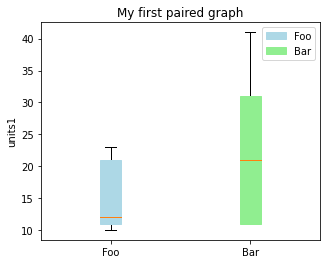

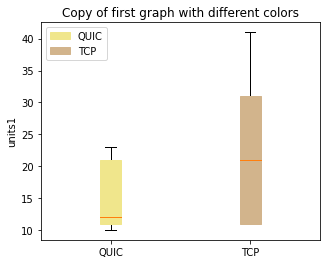

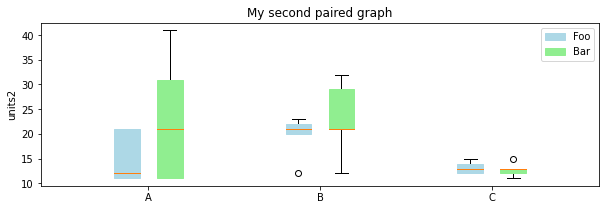

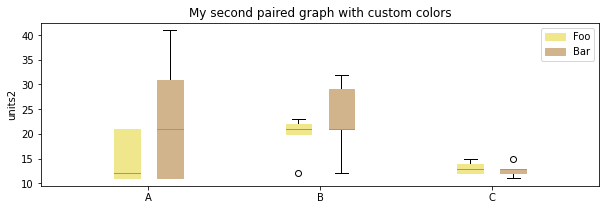

In [36]:
foo, bar = ([10,12,21,23,11],[11,11,41,31,21,])
baz= [
    ([11,12,21,21,11],[11,11,41,31,21,]),
    ([23,22,21,20,12],[12,21,21,32,29,]),
    ([13,12,14,12,15],[15,11,12,13,13,]),
]
graphPair(foo, bar, 'units1', 'My first paired graph', ['Foo', 'Bar'])
graphPair(foo, bar, 'units1', 'Copy of first graph with different colors', colors=['khaki', 'tan'])
graphPairs(baz, ['A', 'B', 'C'], 'units2', 'My second paired graph', ['Foo', 'Bar'])
graphPairs(baz, ['A', 'B', 'C'], 'units2', 'My second paired graph with custom colors', ['Foo', 'Bar'], colors=['khaki', 'tan'])